In [1]:
import SimpleITK as sitk
itkimage = sitk.ReadImage('Case00.mhd')
imgs = sitk.GetArrayFromImage(itkimage)

In [13]:
imgs.shape

(47, 512, 512)

In [11]:
from skimage.exposure import equalize_adapthist
a = equalize_adapthist(imgs[2], clip_limit=0.05)
a.min()

0.0

(47, 256, 256)
15
(16, 128, 128)


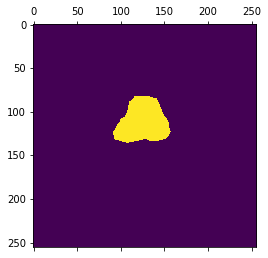

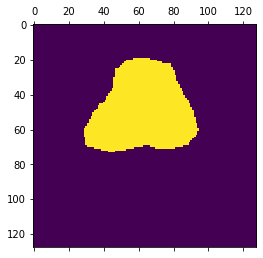

In [11]:
import matplotlib.pyplot as plt
import numpy as np
class Normalize:
    def __init__(self):
        pass

    def __call__(self, img):
        
        return (img - img.min()) / (img.max() - img.min())
    
    def __repr__(self):
        return self.__class__.__name__

class Standardize:
    """
    Apply Z-score normalization to a given input tensor, i.e. re-scaling the values to be 0-mean and 1-std.
    """
    def __init__(self, eps=1e-10, **kwargs):
        self.eps = eps
    def __call__(self, img):
        mean = np.mean(img)
        std = np.std(img)
        img = (img - mean) / np.clip(std, a_min=self.eps, a_max=None)
        return img
    def __repr__(self):
        return self.__class__.__name__
import random
from skimage.transform import resize
class RandomResize:
    def __init__(self, scale = 1.3, p=0.99 ):
        self.size = scale
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            depth, height, width  = img.shape[-3:]
            img = resize(img, (depth*self.size, height*self.size, width*self.size), preserve_range=True)
        return img
    def __repr__(self):
        return self.__class__.__name__ + '(scale={})'.format(self.scale)
class CenterCrop:
    def __init__(self, size=(16, 128, 128)):
        self.size = size

    def __call__(self, img, ):
        depth, height, width  = img.shape
        if depth<self.size[0]:
            img = np.pad(img, (self.size[0]-depth, 0), mode='reflect')
          
            sz = 0
        else:
            sz = (depth - self.size[0] - 1) // 2

        sx = (height - self.size[1] - 1) // 2
        sy = (width - self.size[2] - 1) // 2
        img = img[sz:sz + self.size[0], sx:sx + self.size[1], sy:sy + self.size[2]]
        print(sz)
        return img
    
    def __repr__(self):
        return self.__class__.__name__ + '(size={}, {}, {})'.format(self.size[0], self.size[1], self.size[2])

std = 0.7
data = r'C:\Users\69068\Downloads\npy\Case00_segmentation.npy'#'C:\Users\69068\Downloads\npy\Case00.npy'
data = np.load(data)
print(data.shape)
plt.matshow(data[15])
data = CenterCrop()(data)
print(data.shape)
plt.matshow(data[0])

In [52]:
import numpy as np
data = np.load(r'q\tensor([0]).npz')
pred = data['pred'][0,0].astype(float)
y = data['y'][0,0]
print(pred.shape, y.shape)
print(pred.sum(), y.sum())
pred = CenterCrop()(pred)
y = CenterCrop()(y)
import matplotlib.pyplot as plt
# plt.subplot(211)
# plt.matshow(pred[10])
# plt.subplot(221)
def dice_coef_np(input, target, eps=1e-7):
    input = np.ravel(input)
    target = np.ravel(target)
    intersection = (input * target).sum()

    return (2. * intersection) / (input.sum() + target.sum() + eps)
print(dice_coef_np(pred, y ))
# plt.matshow(y[10])
# plt.matshow(pred[10])

(24, 256, 256) (24, 256, 256)
478034.0 16251.0
3
3
0.14817461959476858


In [18]:
import os
fileList =  os.listdir(r'C:\Users\69068\Downloads\npy')
fileList = sorted((x for x in fileList if '.npy' in x))
imgs= []
masks = []
for filename in fileList:
    if 'segm' in filename.lower():
        masks.append(filename)
    else:
        imgs.append(filename)


In [1]:
import pandas as pd
a =   pd.read_csv('dataset\prostate\PROMISE12.csv')['t2w']

In [7]:
import random
random.randint(0,3)

2

In [19]:
import numpy as np


def random_crop_to_labels(img_numpy, label):
    """
    Random center crop near the label area
    """
    target_indexs = np.where(label > 0)
    [img_d, img_h, img_w] = img_numpy.shape
    [max_D, max_H, max_W] = np.max(np.array(target_indexs), axis=1)
    [min_D, min_H, min_W] = np.min(np.array(target_indexs), axis=1)
    [target_depth, target_height, target_width] = np.array([max_D, max_H, max_W]) - np.array([min_D, min_H, min_W])
    Z_min = int((min_D - target_depth * 1.0 / 2) * np.random.sample())
    Y_min = int((min_H - target_height * 1.0 / 2) * np.random.sample())
    X_min = int((min_W - target_width * 1.0 / 2) * np.random.sample())

    Z_max = int(img_d - ((img_d - (max_D + target_depth * 1.0 / 2)) * np.random.sample()))
    Y_max = int(img_h - ((img_h - (max_H + target_height * 1.0 / 2)) * np.random.sample()))
    X_max = int(img_w - ((img_w - (max_W + target_width * 1.0 / 2)) * np.random.sample()))

    Z_min = int(np.max([0, Z_min]))
    Y_min = int(np.max([0, Y_min]))
    X_min = int(np.max([0, X_min]))

    Z_max = int(np.min([img_d, Z_max]))
    Y_max = int(np.min([img_h, Y_max]))
    X_max = int(np.min([img_w, X_max]))

    return img_numpy[Z_min: Z_max, Y_min: Y_max, X_min: X_max], label

class RandomCropToLabels(object):

    def __call__(self, img_numpy, label):
        return random_crop_to_labels(img_numpy, label)

img = np.load('Case00.npy')
label = np.load('Case00_segmentation.npy')
i, l = RandomCropToLabels()(img, label)
print(i.shape)

(47, 223, 243)


In [135]:
import torch
from torch import long, nn
from torch.nn import functional as F
f = torch.rand((1,8),requires_grad=True)
y = torch.tensor([0],dtype=long)
cls = nn.Linear(8,4)
logit = cls(f)
p = F.softmax(logit, dim=-1)
loss = F.nll_loss(F.log_softmax(logit, dim=-1),y)
print('f:  ', f)
print('logit:  ', logit)
print('p:  ', p)

f:   tensor([[0.5030, 0.9735, 0.2667, 0.2745, 0.7932, 0.6705, 0.4043, 0.8860]],
       requires_grad=True)
logit:   tensor([[ 0.4965,  0.0016, -0.0543,  0.7538]], grad_fn=<AddmmBackward0>)
p:   tensor([[0.2874, 0.1752, 0.1657, 0.3717]], grad_fn=<SoftmaxBackward0>)


In [136]:
dl = torch.autograd.grad(loss,logit,retain_graph=True)[0]
print(dl)

tensor([[-0.7126,  0.1752,  0.1657,  0.3717]])


In [137]:
df = torch.autograd.grad(loss,f,retain_graph=True)[0]
print(df)

tensor([[ 0.1781, -0.0415, -0.0221,  0.0287, -0.0780,  0.1257, -0.2017,  0.2374]])


In [141]:
w = cls.weight
w.shape

torch.Size([4, 8])

In [143]:
dl@w

tensor([[ 0.1781, -0.0415, -0.0221,  0.0287, -0.0780,  0.1257, -0.2017,  0.2374]],
       grad_fn=<MmBackward0>)

In [162]:
import torch
a1 = torch.rand(1,4)
a2 = torch.rand(1,4)
w = torch.rand(4,8)
cos1 = torch.cosine_similarity(a1, a2)
cos2 = torch.cosine_similarity(a1@w, a2@w)
print(cos1, cos2)

tensor([0.7234]) tensor([0.9809])


[0. 1.]


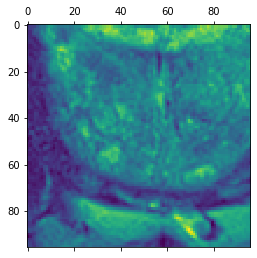

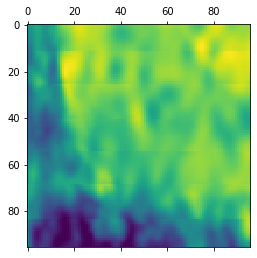

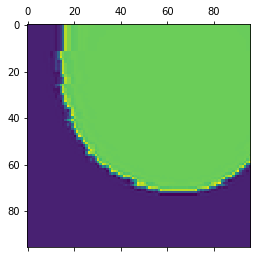

In [20]:
import nibabel as nib
from dataset.prostate import UCL, Promise12, UCLm
import dataset.transforms as T
import dataset.transformsm as Tm
import numpy as np

train_transform = Tm.Compose([
    Tm.RandomZoom(),
    Tm.RandomCrop((16,96,96)),
    Tm.RandomFlip(),
    Tm.RandomRotate(),
    Tm.RandomRotate90(),
    Tm.Normalize(),
    Tm.Standardize(),
    Tm.AdditiveGaussianNoise()
])
m1 = r'D:\ucl_dataset\t2w\Patient001061633_study_0.nii.gz'
m2 = r'D:\ucl_dataset\adc\Patient001061633_study_0_adc-0.nii.gz'
y = r'D:\ucl_dataset\prostate_mask\Patient001061633_study_0.nii.gz'

t2w = nib.load(m1).get_fdata().transpose(2,0,1)
adc = nib.load(m2).get_fdata().transpose(2,0,1)
y = nib.load(y).get_fdata().transpose(2,0,1)
print(np.unique(y))
t2w, adc, y = train_transform(t2w, adc, y)
import matplotlib.pyplot as plt
plt.matshow(t2w[8])
plt.matshow(adc[8])
plt.matshow(y[8])

In [17]:
lbl = y
lbl

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1.

In [19]:
import numpy as np
import scipy.ndimage as ndimage
def random_zoom(img_numpy, min_percentage=0.8, max_percentage=1.1):
    """
    :param img_numpy: 
    :param min_percentage: 
    :param max_percentage: 
    :return: zoom in/out aigmented img
    """
    z = np.random.sample() * (max_percentage - min_percentage) + min_percentage
    zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
    return ndimage.interpolation.affine_transform(img_numpy, zoom_matrix)
random_zoom(lbl)

C:\Users\69068\AppData\Local\Temp\ipykernel_12028\1204712828.py:15: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  return ndimage.interpolation.affine_transform(img_numpy, zoom_matrix)


array([[[-7.89962703e-71,  6.52130213e-70, -7.39072491e-69, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.10848614e-69,  4.32935863e-55, -3.67361721e-54, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.34473043e-68, -3.67361721e-54,  3.11719693e-53, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 4.21998028e-72, -6.59723681e-72,  6.90131418e-70, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.62653091e-70, -2.45841668e-56,  2.08605537e-55, ...,
          0.00000000e+00,  0.00000000e

In [2]:
from model.unet3d import UNet3D
model = UNet3D(1,1)

In [3]:
model

UNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (dropout): Dropout3d(p=0.5, inplace=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout3d(p=0.5, inplace=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), str

In [19]:
import torch
import torch.nn.functional as F
logits1 = torch.rand(8,2,16,200,200)
logits2 = torch.rand(8,2,16,200,200)

In [25]:
probs1 =  F.softmax(logits1, dim=1)
probs2=  F.softmax(logits2, dim=1)

m = 0.5 * (probs1 + probs2)
loss = 0.0
loss += F.kl_div(F.log_softmax(logits1, dim=1), m, reduction="none") 
loss += F.kl_div(F.log_softmax(logits2, dim=1), m, reduction="none") 
loss.mean()

tensor(0.0102)

In [26]:
probs1 =  F.softmax(logits1, dim=1).permute(0,2,3,4,1).reshape(-1,2)
probs2=  F.softmax(logits2, dim=1).permute(0,2,3,4,1).reshape(-1,2)

m = 0.5 * (probs1 + probs2)
loss = 0.0
loss += F.kl_div(F.log_softmax(logits1.permute(0,2,3,4,1).reshape(-1,2), dim=1), m, reduction="none") 
loss += F.kl_div(F.log_softmax(logits2.permute(0,2,3,4,1).reshape(-1,2), dim=1), m, reduction="none") 
loss.mean()

tensor(0.0102)

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
logits1 = torch.rand(8,16)
net = nn.Linear(16,2)
with torch.no_grad():
    out = net(logits1)

In [63]:
logits1 = torch.rand(8,2,16,200,200)
logits2 = torch.rand(8,2,16,200,200)
(logits1*logits2).sum(dim=1,keepdim=True).shape

torch.Size([8, 1, 16, 200, 200])

In [64]:
def get_weight(input_):
    with torch.no_grad():
        entropy = -input_ * torch.log(input_ + 1e-5)
        entropy = torch.sum(entropy, dim=1, keepdim=True)
        weight = 1.0 + torch.exp(-entropy)
        weight = weight / torch.sum(weight)
    return weight

In [67]:
l = torch.rand((8,2,16,200,200),requires_grad=True)
w = get_weight(torch.softmax(l,dim=1))

In [68]:
w.sum()

tensor(1.0000)